In [4]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

In [5]:
Pass="1"
config="2"
useGrinch=False

In [6]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')



W2min: 0
W2max: 1.5
dxmin: -0.481
dxmax: 0.498
dymin: -0.822
dymax: 0.8
dybgmin: -1.4
dybgmax: 1.4
Q2: 3
Coin Min: 95 Coin Max: 106


In [7]:

fileNum=1
#generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/generic{fileNum}.npz")
simconfig=config
if config=="4a" or config=="4b":
    simconfig="4"
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{simconfig}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN4/insimulation0.npz")

print(genericSim.files)
print(genericSimIN.files)


['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig', 'mc_sigOld', 'mc_sigPol', 'mc_BETA', 'mc_THETA']


In [8]:
sigma=genericSimIN["mc_sig"]
sigmaOld=genericSimIN["mc_sigOld"]
sigmaPol=genericSimIN["mc_sigPol"]
mcBeta=genericSimIN["mc_BETA"]
mcTheta=genericSimIN["mc_THETA"]
w2=genericSimIN["W2"]
dx=genericSimIN["dx"]
dy=genericSimIN["dy"]

cut=(w2<W2max)&(w2>W2min)&(dx<dxmax)&(dx>dxmin)&(dy<dymax)&(dy>dymin)

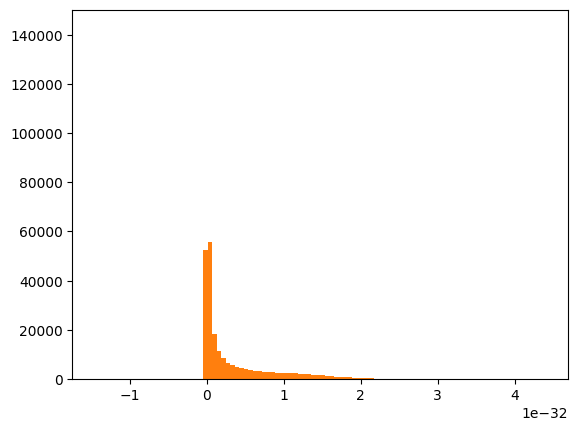

In [9]:
d=plt.hist(sigma,bins=100)
d=plt.hist(sigmaOld,bins=100)

/tmp/ipykernel_21957/2112122102.py:1: RuntimeWarning: divide by zero encountered in divide
  d=plt.hist(sigma/sigmaOld*1e6,bins=100,range=(0,15))


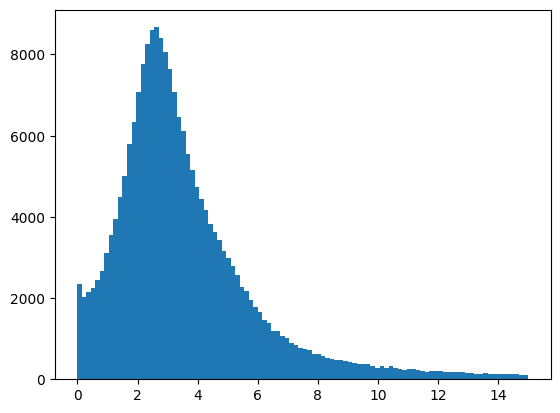

In [10]:
d=plt.hist(sigma/sigmaOld*1e6,bins=100,range=(0,15))

In [11]:
cleanup=(abs(w2)<30) & (w2>-5)


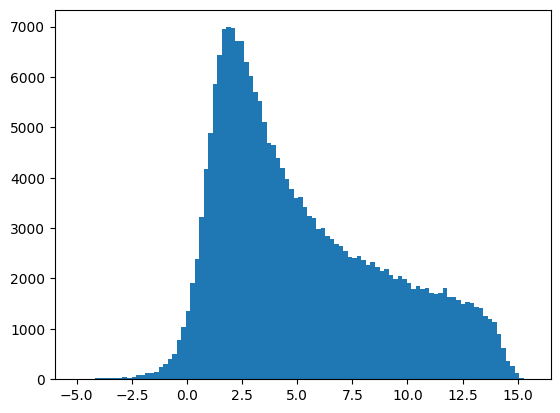

In [12]:
d=plt.hist(w2[cleanup],bins=100)

/tmp/ipykernel_21957/2389097699.py:1: RuntimeWarning: divide by zero encountered in divide
  d=plt.hist2d(w2[cleanup],sigma[cleanup]/sigmaOld[cleanup]*1e6,bins=50,range=((-1,2),(-1,10)))


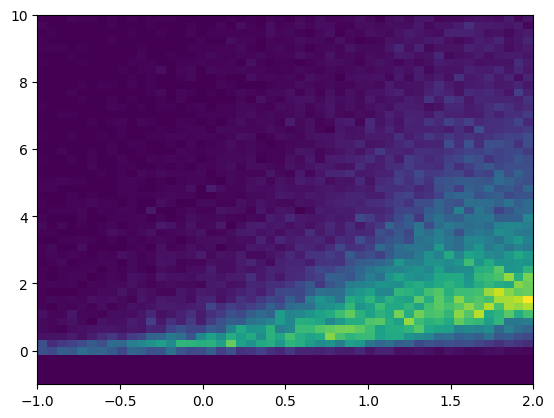

In [13]:
d=plt.hist2d(w2[cleanup],sigma[cleanup]/sigmaOld[cleanup]*1e6,bins=50,range=((-1,2),(-1,10)))

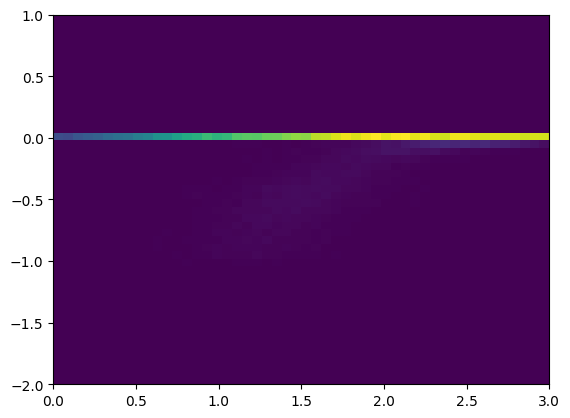

In [14]:
d=plt.hist2d(w2[cleanup],sigmaPol[cleanup]/sigma[cleanup],bins=50,range=((0,3),(-2,1)))

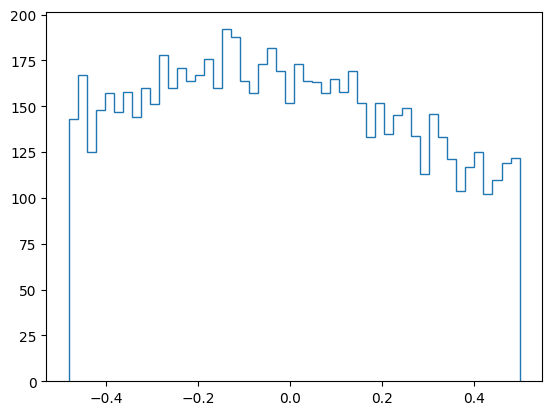

In [15]:
d=plt.hist(dx[cut],bins=50,histtype='step')


(-0.481, 0.498)

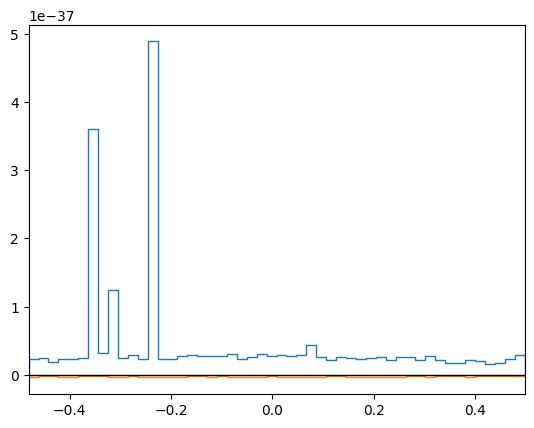

In [16]:
#d=plt.hist(dx[cleanup],bins=50,weights=sigmaOld[cleanup]*1e-6,histtype='step')
d=plt.hist(dx[cut],bins=50,weights=sigma[cut],histtype='step')
d=plt.hist(dx[cut],bins=50,weights=sigmaPol[cut],histtype='step')
plt.axhline(0,linewidth=1,color='black')
plt.xlim(dxmin,dxmax)

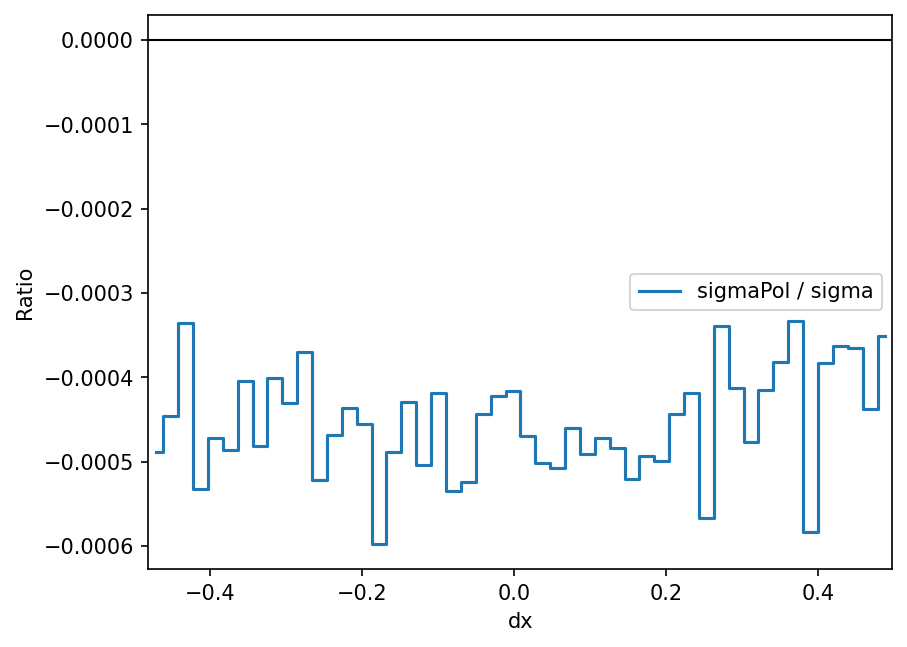

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define bin edges
bins = np.linspace(dxmin, dxmax, 51)  # 50 bins between dxmin and dxmax

# Compute histograms
h1, _ = np.histogram(dx[cleanup], bins=bins, weights=sigma[cleanup])
h2, _ = np.histogram(dx[cleanup], bins=bins, weights=sigmaPol[cleanup])

# Avoid divide-by-zero by masking
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.divide(h2, h1)
    ratio[~np.isfinite(ratio)] = 0  # Set NaNs and infs to 0

# Compute bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot the ratio
plt.figure(dpi=150)
plt.plot(bin_centers, ratio, drawstyle='steps-mid', label='sigmaPol / sigma')
plt.axhline(0, color='black', linewidth=1)
plt.xlim(dxmin, dxmax)
plt.ylabel("Ratio")
plt.xlabel("dx")
plt.legend()
plt.show()
A_avg = np.average(ratio, weights=h1)


In [18]:
A_avg

-0.00045258901472183024